In [1]:
import time
import json
from data_crawler import data_crawler


# { period : [ limit, milliseconds ] } (limit <= 200)
supported_period = { "1m" : [ 100,  60000 ],
                     "5m" : [ 100, 300000 ],
                     "15m" : [ 100, 900000 ],
                     "1H" : [ 100, 3600000 ],
                     "6H" : [ 100, 21600000 ] }

# { period : [ datas, lasttime ] }
download_format = { "1m" : [ None, None ],
                    "5m" : [ None, None ],
                    "15m" : [ None, None ],
                    "1H" : [ None, None ],
                    "6H" : [ None, None ] }  

supported_ticker = { "BTCUSDT_UMCBL" }
ticker = "BTCUSDT_UMCBL"

data_crawler = data_crawler(None, supported_ticker, supported_period, download_format)

datas = data_crawler.get_downloaded_datas()[ticker]

for period in download_format.keys():
    data = datas[period][0]
    print(period, type(data), len(data))
    
# [ 'timestamp in milliseconds', 'Opening price', 'Highest price', 'Lowest price', 'Close price',
#   'Base currency trading volume', `Quote currency trading volume` ]

Succeed to download datas [BTCUSDT_UMCBL / 1m / 1695999038966 / 1696005038966]
Succeed to download datas [BTCUSDT_UMCBL / 5m / 1695975038966 / 1696005038966]
Succeed to download datas [BTCUSDT_UMCBL / 15m / 1695915038966 / 1696005038966]
Succeed to download datas [BTCUSDT_UMCBL / 1H / 1695645038966 / 1696005038966]
Succeed to download datas [BTCUSDT_UMCBL / 6H / 1693845038966 / 1696005038966]
1m <class 'list'> 100
5m <class 'list'> 100
15m <class 'list'> 100
1H <class 'list'> 100
6H <class 'list'> 100


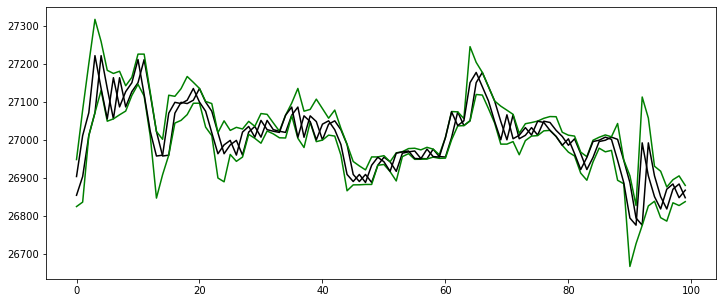

In [2]:
# 가격 그래프로 불러오기

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

period = "15m" # 봉 기준
datas_ = datas[period][0] # 데이터
    
datas_ = pd.DataFrame(datas_, columns=['time', 'open', 'high', 'low', 'close', 'volume', 'q_volume'])

plt.figure(figsize=(12,5))
plt.plot(datas_['open'], 'black')
plt.plot(datas_['high'], 'green')
plt.plot(datas_['low'], 'green')
plt.plot(datas_['close'], 'black')
plt.show()


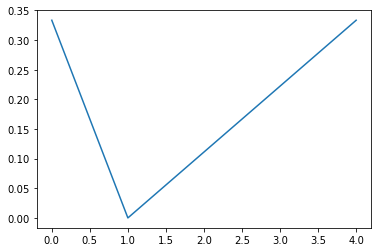

One example is here. :  26854.7 26948.4 26825.1 26903.9 26883.025 2087.555 2.0 [0.33333333 0.         0.11111111 0.22222222 0.33333333]


In [3]:
# 거래량 multiple 계산 방식 구현

volume_profiles = []
test = False

for i in range(len(datas_['time'])):
    volume = datas_['volume'][i]
    open_price = datas_['open'][i]
    high_price = datas_['high'][i]
    low_price = datas_['low'][i]
    close_price = datas_['close'][i]
    center_price = (open_price + high_price + low_price + close_price) / 4
    
    total_div = 5
    div_size = (high_price - low_price) / total_div
    index_pivot = (center_price - low_price) // div_size
    index_pivot = max(min(index_pivot, total_div - 1), 1) # 시고저종 가격을 바탕으로 중심값 선정
    multiple_of_volume = np.array(list(np.linspace(1, 0, int(index_pivot))) \
                                + list(np.linspace(0, 1, int(total_div - index_pivot + 1))[1:]))
    multiple_of_volume /= sum(multiple_of_volume)
    
    for j in range(len(multiple_of_volume)):
        for k in range(int(volume * multiple_of_volume[j] / total_div)):
            volume_profiles.append(low_price + j * div_size)
    
    if test or i == 0:
        plt.plot(multiple_of_volume)
        plt.show()
        print("One example is here. : ", open_price, high_price, low_price, close_price, center_price, volume, index_pivot, multiple_of_volume)


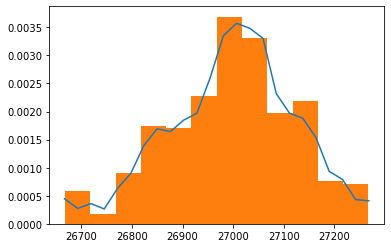

In [4]:
import seaborn as sns
from scipy.stats import gaussian_kde

x = np.linspace(min(volume_profiles) - 1, max(volume_profiles) + 1, 24)
kde = gaussian_kde(volume_profiles)
plt.plot(x, kde(x), label='KDE')
plt.hist(volume_profiles, density=True, bins=12)
plt.show()

C:\Users\devtae\AppData\Local\Temp/ipykernel_5852/3045513074.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  derivative_volume_profile = np.array(derivative_volume_profile)


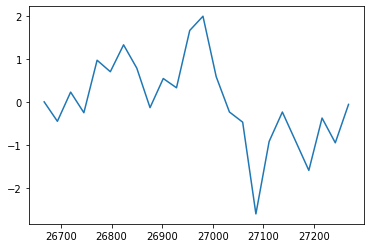

In [5]:
derivative_volume_profile = []

for i in range(len(x)):
    if i == 0:
        derivative_volume_profile.append(0)
    else:
        derivative_volume_profile.append((kde(x[i]) - kde(x[i-1])))
        
derivative_volume_profile = np.array(derivative_volume_profile)
derivative_volume_profile -= np.mean(derivative_volume_profile)
derivative_volume_profile /= np.std(derivative_volume_profile)

plt.plot(x, derivative_volume_profile, label='KDE')
plt.show()

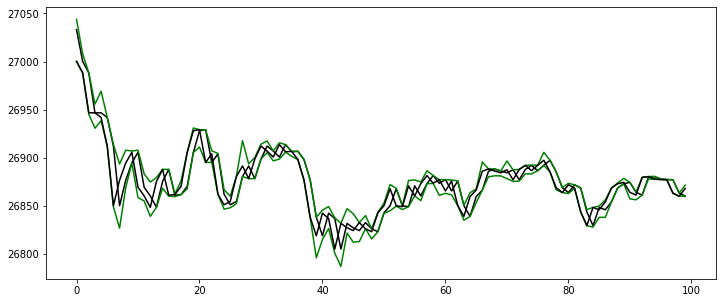

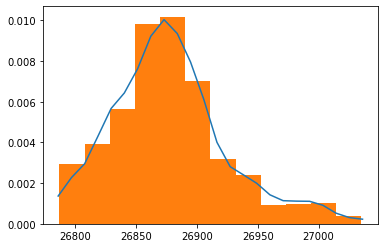

C:\Users\devtae\AppData\Local\Temp/ipykernel_5852/466118263.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  derivative_volume_profile = np.array(derivative_volume_profile)


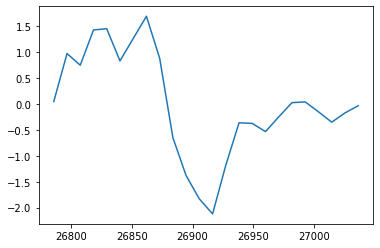

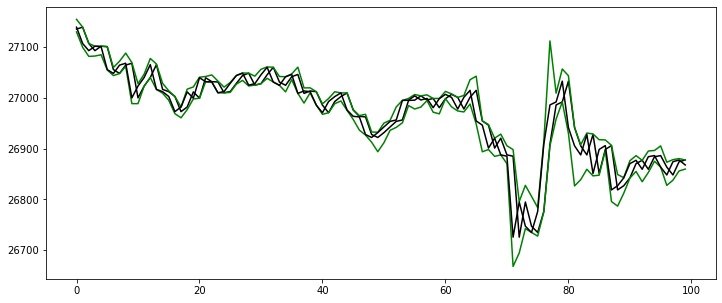

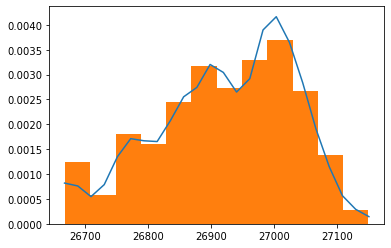

C:\Users\devtae\AppData\Local\Temp/ipykernel_5852/466118263.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  derivative_volume_profile = np.array(derivative_volume_profile)


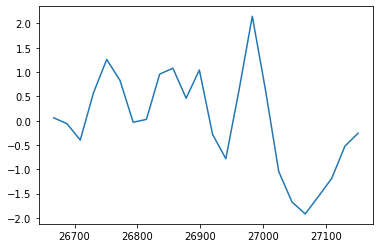

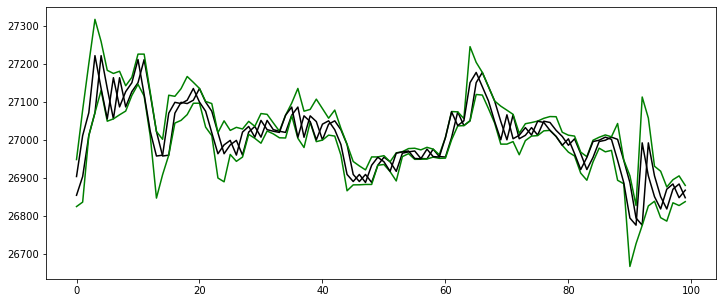

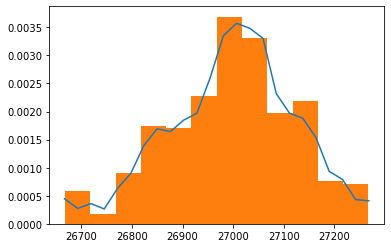

C:\Users\devtae\AppData\Local\Temp/ipykernel_5852/466118263.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  derivative_volume_profile = np.array(derivative_volume_profile)


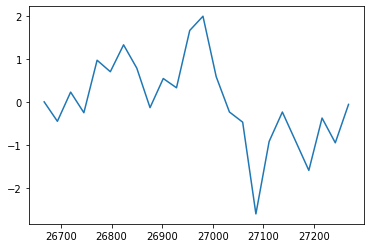

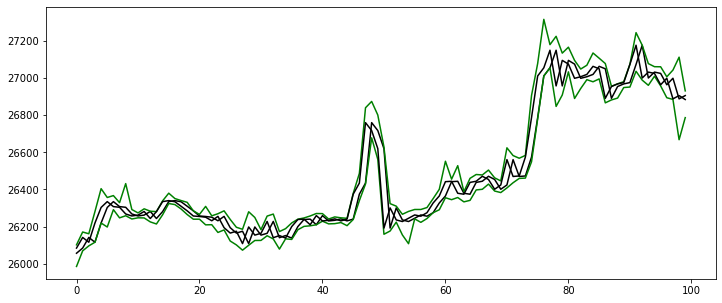

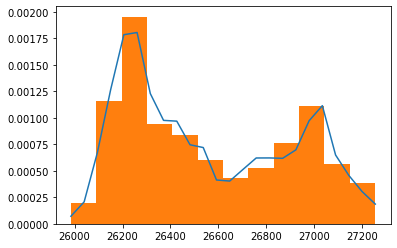

C:\Users\devtae\AppData\Local\Temp/ipykernel_5852/466118263.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  derivative_volume_profile = np.array(derivative_volume_profile)


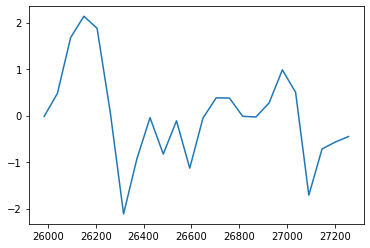

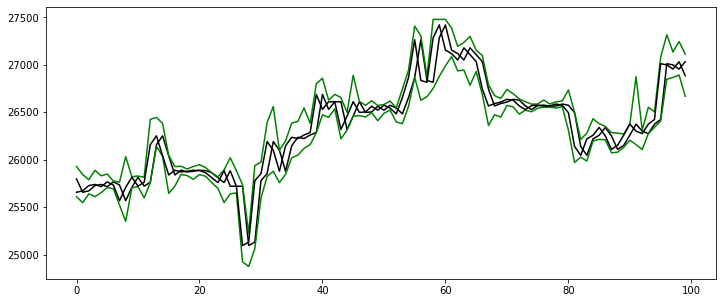

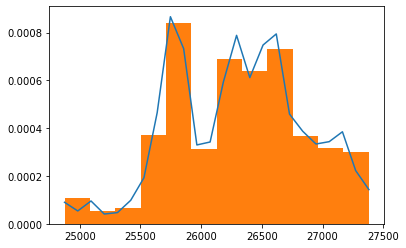

C:\Users\devtae\AppData\Local\Temp/ipykernel_5852/466118263.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  derivative_volume_profile = np.array(derivative_volume_profile)


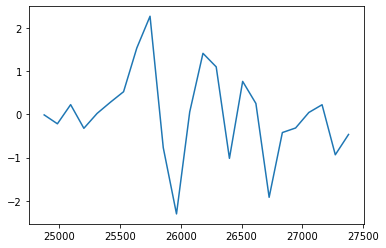

In [6]:
for period in supported_period.keys():
    
    # 데이터 Pandas 변환
    datas_ = datas[period][0]
    
    for idx, data in enumerate(datas_):
        data = list(map(float, data))
        datas_[idx] = data
    
    datas_ = pd.DataFrame(datas_, columns=['time', 'open', 'high', 'low', 'close', 'volume', 'q_volume'])
    
    # 거래량 multiple 계산 방식 구현
    volume_profiles = []
    
    for i in range(len(datas_['time'])):
        volume = datas_['volume'][i]
        open_price = datas_['open'][i]
        high_price = datas_['high'][i]
        low_price = datas_['low'][i]
        close_price = datas_['close'][i]
        center_price = (open_price + high_price + low_price + close_price) / 4
        
        total_div = 5
        div_size = (high_price - low_price) / total_div
        index_pivot = (center_price - low_price) // div_size
        index_pivot = max(min(index_pivot, total_div - 1), 1) # 시고저종 가격을 바탕으로 중심값 선정
        multiple_of_volume = np.array(list(np.linspace(1, 0, int(index_pivot))) \
                                    + list(np.linspace(0, 1, int(total_div - index_pivot + 1))[1:]))
        multiple_of_volume /= sum(multiple_of_volume)
        
        for j in range(len(multiple_of_volume)):
            for k in range(int(volume * multiple_of_volume[j] / total_div)):
                volume_profiles.append(low_price + j * div_size)

    # 주가 그래프 그리기
    plt.figure(figsize=(12,5))
    plt.plot(datas_['open'], 'black')
    plt.plot(datas_['high'], 'green')
    plt.plot(datas_['low'], 'green')
    plt.plot(datas_['close'], 'black')
    plt.show()
    
    # KDE 적용
    x = np.linspace(min(volume_profiles) - 1, max(volume_profiles) + 1, 24)
    kde = gaussian_kde(volume_profiles)
    plt.plot(x, kde(x), label='KDE')
    plt.hist(volume_profiles, density=True, bins=12)
    plt.show()
    
    # 미분 적용 (난이도)
    derivative_volume_profile = []

    for i in range(len(x)):
        if i == 0:
            derivative_volume_profile.append(0)
        else:
            derivative_volume_profile.append((kde(x[i]) - kde(x[i-1])))
    
    derivative_volume_profile = np.array(derivative_volume_profile)
    derivative_volume_profile -= np.mean(derivative_volume_profile)
    derivative_volume_profile /= np.std(derivative_volume_profile)
    
    plt.plot(x, derivative_volume_profile, label='KDE')
    plt.show()
    